<a href="https://colab.research.google.com/github/sugarghost/hanghae99_AI_PLUS_2/blob/main/2_HOMEWORK_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [2주차] 기본과제: 주어진 문장에서 나올 다음 단어를 예측하는 모델 구현

In [1]:
!pip install datasets sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 1.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Last word prediction dataset 준비

In [2]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
# [MY CODE] pad_sequence import
from torch.nn.utils.rnn import pad_sequence



ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')

# [my code] collate_fn 형식 변경
def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    tokens = tokenizer(row['text'], padding=True, truncation=True, max_length=max_len).input_ids
    labels.append(tokens[-2])
    texts.append(torch.LongTensor(tokens[:-2]))

  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [3]:
from torch import nn
from math import sqrt


class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)
    score = score / sqrt(self.d_model)

    if mask is not None:
      score = score + (mask * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v)
    result = self.dense(result)

    return result


# [MY CODE] 정확도가 계속 안올라가서 멀티헤드 어텐션 가져옴
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.input_dim = input_dim
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads  # D' = D / H

        # Q, K, V 각각 가중치 매트릭스 생성
        self.W_q = nn.Linear(input_dim, d_model)
        self.W_k = nn.Linear(input_dim, d_model)
        self.W_v = nn.Linear(input_dim, d_model)
        self.dense = nn.Linear(d_model, d_model)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask):
        batch_size, seq_len, _ = x.shape

        # Q, K, V 생성
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2)

        score = torch.matmul(Q, K.transpose(-1, -2))
        score = score / sqrt(self.d_head)

        if mask is not None:
          # [MY CODE] 마스크 차원 변경
          mask = mask[:, None, :]
          score = score + (mask * -1e9)

        score = self.softmax(score)

        output = torch.matmul(score, V)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        output = self.dense(output)
        return output

In [4]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    # self.mha = MultiHeadAttention(input_dim, d_model, n_heads) # [MY CODE] 멀티헤드 어텐션 추가했다가 취소
    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

    # [MY CODE] Layer 추가 및 드롭아웃 적용
    '''
    self.layernorm1 = nn.LayerNorm(d_model)
    self.layernorm2 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(dropout_param)
    '''
  def forward(self, x, mask):

    # [MY CODE] Multi-Head Attention 적용 취소
    '''
    mha = self.mha(x, mask)
    mha = self.dropout(mha)
    x = self.layernorm1(mha + x)

    ffn = self.ffn(x)
    ffn = self.dropout(ffn)
    x = self.layernorm2(ffn + x)
    '''
    x = self.sa(x, mask)
    x = self.ffn(x)

    return x

In [5]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


## Loss function 및 classifier output 변경
  - 마지막 token id를 예측하는 것이기 때문에 binary classification이 아닌 일반적인 classification 문제로 바뀝니다. MNIST 과제에서 했던 것 처럼 loss와 `TextClassifier`의 출력 차원을 잘 조정하여 task를 풀 수 있도록 수정하시면 됩니다.

In [6]:
class TextClassifier(nn.Module):
  # [MY CODE] 매개변수 조정
  def __init__(self, vocab_size, d_model, n_layers, dff):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    # 멀티헤드 어텐션 취소함
    # self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, n_heads, dff, dropout_param) for _ in range(n_layers)])
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, vocab_size) # [my code] 출력 차원을 어휘 크기로 변경

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x

# [MY CODE] 5-layer 4-head Transformer
#model = TextClassifier(len(tokenizer), 128, 5, 4, 256, 0.1) 멀티헤드 취소
model = TextClassifier(len(tokenizer), 32, 2, 32)

In [7]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
# loss_fn = nn.BCEWithLogitsLoss()
# [MY CODE] 손실 함수를 다중 클래스 분류 용도로 변경
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)

In [8]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1) # [MY CODE] 가장 큰 값을 가진 인덱스 추출
    # preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt


# [MY CODE] 측정 함수 추가
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

## 학습 결과 report
 - 기존 Transformer 실습에서 사용한 모델로 last word prediction을 학습하고 학습 경과를 report하면 됩니다.

Epoch   0 | Train Loss: 1502.5111849308014
=========> Train acc: 0.558 | Test acc: 0.564
Epoch   1 | Train Loss: 1165.8323737382889
=========> Train acc: 0.558 | Test acc: 0.564
Epoch   2 | Train Loss: 1130.876741528511
=========> Train acc: 0.558 | Test acc: 0.564
Epoch   3 | Train Loss: 1096.6399809122086
=========> Train acc: 0.558 | Test acc: 0.564
Epoch   4 | Train Loss: 1078.4120353460312
=========> Train acc: 0.558 | Test acc: 0.564
Epoch   5 | Train Loss: 1070.6014961004257
=========> Train acc: 0.558 | Test acc: 0.564
Epoch   6 | Train Loss: 1060.687424659729
=========> Train acc: 0.558 | Test acc: 0.564
Epoch   7 | Train Loss: 1053.6842467784882
=========> Train acc: 0.558 | Test acc: 0.563
Epoch   8 | Train Loss: 1043.4821281433105
=========> Train acc: 0.558 | Test acc: 0.564
Epoch   9 | Train Loss: 1032.435985326767
=========> Train acc: 0.560 | Test acc: 0.565
Epoch  10 | Train Loss: 1021.5357375144958
=========> Train acc: 0.562 | Test acc: 0.566
Epoch  11 | Train Loss: 

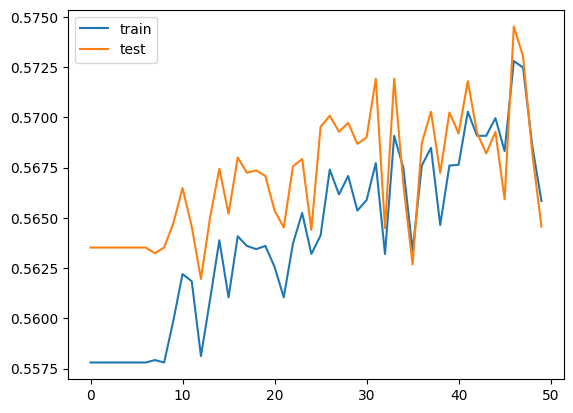

In [9]:
# [MY CODE] 멀티헤드 + 복잡도 이것저것 시도해보다가 포기
n_epochs = 50
# [MY CODE] plot 용 변수 추가
train_acc_list = []
test_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda').long() # [MY CODE] 레이블을 정수형으로 변경

    #preds = model(inputs)[..., 0]
    preds = model(inputs) # [MY CODE] Logits 반환
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    # [MY CODE] 결과 기록
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

# [MY CODE] plot
plot_acc(train_acc_list, test_acc_list)


    # 멀티헤드, 차원 복잡도 증가 다 해봤는데 정확도는 변화가 없음
    # 아마 기반 데이터의 문제가 아닐까, 문장 마지막이 . 으로 찍히는 경우가 많은 경우 발생하는 문제가 아닐까 의심됨.